# Deep Probabilistic Generative Models - Restricted Boltzmann Machine

In this lab exercise, you will code a Restricted Boltzmann Machine with Gaussian observed random variables and Bernoulli latent variables. The explanation of the model and the derivation of all formulas are given in the PDF available from the course website, lab exercise section. Please, read it carefully to understand what is going on!

In [12]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import itertools
import random
import math
import time
import sklearn.datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

%matplotlib inline

In [13]:
# samples1-2 shape must be (n samples, 2)
def plot_samples(samples1, samples2=None):
    fig, ax = plt.subplots()

    ax.scatter(samples1[:,0], samples1[:,1], marker="x", color="blue")
    if samples2 is not None:
        ax.scatter(samples2[:,0], samples2[:,1], marker="x", color="red")

## Data generation

The data we will use in the lab exercise looks like a ring.
You can see the it would be difficult fit this dataset with a Gaussian Mixture Model: we would need to use many Gaussians and each one would imperfectly fit a subset of the data space.

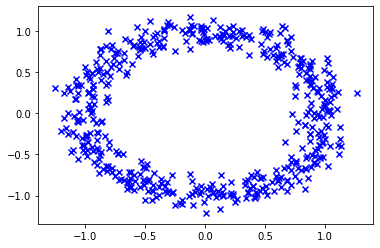

In [15]:
target_samples, y = sklearn.datasets.make_circles(n_samples=1000, noise=0.1, factor=0.2)
target_samples = target_samples[y == 0]
target_samples = torch.from_numpy(target_samples).float()

plot_samples(target_samples)

## Restricted Boltzmann Machine code

The class below represents a restricted Boltzmann Machine.
There are 3 functions you need to code:

- forward: it should return the free energy of the input
- p_x_given_z: it should return the mean and variance for each observed variable
- p_z_given_x: it should return the bernoulli parameter for each latent variable

Note that due to batching operations (i.e. each function takes as input a batch of data, not a single data point), computations that contains the matrix W will be tricky to implement!
Each time you have a sum with W appearing inside (look at the PDF!) it should be implemented as a matrix multplication, i.e. with the symbol @.
As an example, in the function p_x_given_z bellow you will have the following operation: "z @ self.W.T".
You should take time to to understand how operation broadcasting work and how to implement batched operation in this RBM. You will have to play with the transpose operator...
You should probably read this page on operation broadcasting: https://pytorch.org/docs/stable/notes/broadcasting.html

**Advice:**

- for each tensor, think about what each dimension contains
- how does it compares to the way we wrote it mathematically in the PDF?

**Sampling functions in Pytorch:**
You will need the following sampling function from Pytorch:

- torch.normal
- torch.bernoulli

**WARNING:** Read the documentation! torch.normal takes as argument the **standard deviation** and not the **variance**, so you should pass sigma_squared.sqrt()! Always be careful when you use functions from a library: take time to read the documentation.

**Stable operation**:

To compute the value log(1 + exp(...)), you should use the softplus functino which is more stable: https://pytorch.org/docs/stable/nn.functional.html?highlight=softplus#torch.nn.functional.softplus

In [4]:
class RBM(nn.Module):
    def __init__(self, n_visible = 2, n_hidden=10):
        super().__init__()
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        
        # Create parameters:
        # See the PDF file for a description of each parameter
        
        self.b = nn.Parameter(torch.empty(n_visible))
        # because sigma squared should be greater than zero (variance),
        # we instead take parameter log_sigma_squared which is unconstrained.
        # as usual, to get sigma_squared you can do:
        # sigma_squared = self.log_sigma_squared.exp()
        self.log_sigma_squared = nn.Parameter(torch.empty(n_visible))
        
        self.W = nn.Parameter(torch.empty(n_visible, n_hidden))
        self.c = nn.Parameter(torch.empty(n_hidden))
        
        self.init_params()
    
    # Initialize parameters:
    # unfortunately, the RBM and training loop we are going to code
    # is really sensitve to initialization...
    # this is not perfect, but at least it works! :)
    def init_params(self):
        with torch.no_grad():
            self.b.fill_(0.)
            self.log_sigma_squared.fill_(math.log(0.1**2))
            self.W.normal_(0., 0.01)
            self.c.normal_(0., 0.1)

    # returns the free energy of x
    # - shape of input x: (batch size, n_visible)
    # - shape of return tensor: (batch size,)
    def forward(self, x):
        # BEGIN TODO
        ...
        # END TODO
        
    # compute the parameters of the conditional distribution p(x | z)
    # - shape of input z: (batch size, n hidden)
    # - shapes of the two returned tensors:
    #   1. mean of the Gaussians mu: (batch size, n_visible)
    #   2. variance of the Gaussians sigma: (batch size, n_visible)
    def p_x_given_z(self, z):
        sigma_squared = self.log_sigma_squared.exp()
        # BEGIN TODO
        ...
        # END TODO
        
        # note the variance is independent of the hidden variable,
        # it is fixed, so we just "extend" the dimension of the vector
        # to fit the output shape
        return mu, sigma_squared.unsqueeze(0).repeat(z.shape[0], 1)
    
    # compute the parameters of the Bernoulli conditional distribution p(z | x)
    # - shape of input x: (batch size, n visible)
    # - output shape: (batch size, n hidden)
    def p_z_given_x(self, x):
        # BEGIN TODO
        ...
        # END TODO

In [5]:
# check shapes of your RBM!
batch_size = 15

machine = RBM()

x = torch.ones((batch_size, machine.n_visible))
f = machine(x)

if f.shape != (batch_size,):
    print("Expected shape: ", (batch_size,))
    print("Returned shape: ", f.shape)
    raise RuntimeWarning("The shape of the free energy tensor is wrong!")


z = torch.ones((batch_size, machine.n_hidden))
mu, sigma_squared = machine.p_x_given_z(z)

if mu.shape != (batch_size, machine.n_visible):
    print("Expected shape: ", (batch_size, machine.n_visible))
    print("Returned shape: ", mu.shape)
    raise RuntimeWarning("The shape of the Gaussian mean tensor is wrong!")

if sigma_squared.shape != (batch_size, machine.n_visible):
    print("Expected shape: ", (batch_size, machine.n_visible))
    print("Returned shape: ", sigma_squared.shape)
    raise RuntimeWarning("The shape of the Gaussian variance tensor is wrong!")


mu = machine.p_z_given_x(x)
if mu.shape != (batch_size, machine.n_hidden):
    print("Expected shape: ", (batch_size, machine.n_hidden))
    print("Returned shape: ", mu.shape)
    raise RuntimeWarning("The shape of the Bernoulli parameter tensor is wrong!")


AttributeError: 'NoneType' object has no attribute 'shape'

## Training loop

During training, we must approximate the loss via Markov Chain Monte Carlo.
It usual to rely on contrastive divergence in the case of RBM training:

- we use a single sample per batch data point in the Monte Carlo approximation of the partition function contribution to the loss
- we start one Markov Chain per data point in the batch
- we only do a few steps, e.g. in general one! this is parameterized by k below
- we take the last sample from each chain

In [6]:
batch_size = target_samples.shape[0] # we just feed all data at once, you can try with smaller batch size
n_epoch = 300 # number of epochs
k = 1 # number of step to take in the Gibbs sampler for contrastive loss

n_visible = target_samples.shape[1]
n_hidden = 100


machine = RBM(n_visible, n_hidden)
# we fix the variance of the observed variables,
# its easier to train this way!
machine.log_sigma_squared.requires_grad_(False)
# optimizer
optimizer = torch.optim.SGD(machine.parameters(), lr=1e-3)


losses = list()
for _ in range(n_epoch):
    for i in range(0, target_samples.shape[0], batch_size):
        optimizer.zero_grad()
        data_samples = target_samples[i:i+batch_size]

        with torch.no_grad():
            # generate sample from your model!
            # and store the in a variable called model_samples
            # BEGIN TODO
            ...
            # END TODO
                
        # the loss function is quite simple
        loss = (machine(data_samples) - machine(model_samples)).mean()
        losses.append(loss.item())

        loss.backward()
        # we use gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_(machine.parameters(), 1)
        optimizer.step()
    
# plot the training loss
plt.plot(np.arange(len(losses)), losses)
plt.show()

NameError: name 'model_samples' is not defined

## Sampling from the trained RBM

We now turn to sampling from our trained model to check if it models the data correctly.
We will run many markov chains in parallel and do several visualization.
In the first one, we will just plot the samples at the timestep of each markov chain.

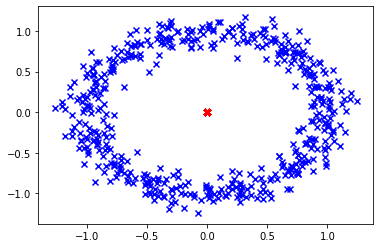

In [7]:
# Sample from the distribution!
# just

n_chains = 500
n_steps = 1000
with torch.no_grad():
    # the vector x contains sample of the observed random variables at each time step for each markov chain
    # at each time step you must do an inplace operation, i.e. x[timestep] = ...
    x = torch.empty(n_steps, n_chains, machine.n_visible)
    
    # we don't plot the hidden random variables so we won't keep track of them,
    # just use a temporary variable z
    # we start with a random vector of binary variables
    z = torch.bernoulli(torch.empty(n_chains, machine.n_hidden).fill_(0.5))
    for timestep in range(n_steps):
        # do one step of Gibbs sampling here and fill x!
        
        # BEGIN TODO
        ...
        # END TODO

# plot the samples at the last timestep of each markov chaine
plot_samples(target_samples, x[-1])

## Visualization of the Gibbs sampling Markov Chain Monter Carlo sampling process

We can visualization the sampling process in two different ways:

- first, we can plot at the sample of each markov chain at each time step
- second, we focus on a single markov chain and observe how it evolves

Note that we use the values x of before for the animation

In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import animation, rc
from IPython.display import HTML


# this is just code for building the animation
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
def animate_mc(animation_data):
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    ax.set_xlim(( -1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))

    sct = ax.scatter([], [], lw=2)

    # initialization function: plot the background of each frame
    def init():
        sct.set_offsets([])
        return (sct,)

    # animation function.  This is called sequentially
    def animate(i):
        #fig = plt.figure()
        #ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))

        data = animation_data[i]
        
        sct.set_offsets(data)
        #sct.set_array(dev_labels)
        
        return sct,
    
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(animation_data), interval=20, blit=True)

    return anim.to_jshtml()

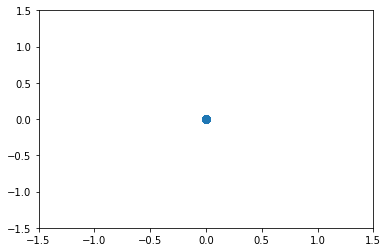

In [9]:
# show the samples of each markov chain at each time step
# you can clic on - to slow down the animation
HTML(animate_mc(x[:20].numpy()))

In [10]:
# this is just code for building the animation
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/
def animate_mc_persitent(animation_data):
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    ax.set_xlim(( -1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))

    sct = ax.scatter([], [], lw=2)

    # initialization function: plot the background of each frame
    def init():
        sct.set_offsets([])
        return (sct,)

    # animation function.  This is called sequentially
    def animate(i):
        #fig = plt.figure()
        #ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))

        data = animation_data[:i]
        
        sct.set_offsets(data)
        #sct.set_array(dev_labels)
        
        return sct,
    
    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(animation_data), interval=20, blit=True)

    return anim.to_jshtml()

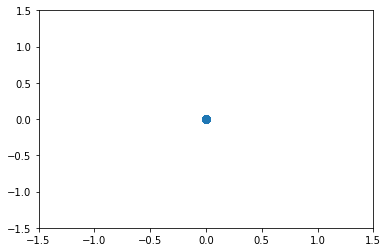

In [11]:
# animation of the evolution of a single chain
# we show the 300 undred first steps of the first chain
HTML(animate_mc_persitent(x[:300,0].numpy()))